In [ ]:
pip install transformers

In [2]:
# 导入必要的库
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertModel, AdamW
from keras.utils import pad_sequences
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tqdm import tqdm
from sklearn.metrics import classification_report, accuracy_score

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

MAX_LEN = 256
BATCH_SIZE = 32
EPOCHS = 1

In [3]:
data = pd.read_csv("suicide_detection_final_cleaned.csv")

In [5]:
# 分割数据为训练集、验证集和测试集
train_data, temp_data = train_test_split(data, test_size=0.5, random_state=42, stratify=data['class'])
valid_data, test_data = train_test_split(temp_data, test_size=0.4, random_state=42, stratify=temp_data['class'])

train_texts = train_data['cleaned_text'].fillna("").tolist()
train_labels = train_data['class'].tolist()
valid_texts = valid_data['cleaned_text'].fillna("").tolist()
valid_labels = valid_data['class'].tolist()
test_texts = test_data['cleaned_text'].fillna("").tolist()
test_labels = test_data['class'].tolist()

In [6]:
# 使用BERT tokenizer对文本进行编码
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)
train_input_ids = [tokenizer.encode(text, add_special_tokens=True, max_length=MAX_LEN, truncation=True) for text in train_texts]
valid_input_ids = [tokenizer.encode(text, add_special_tokens=True, max_length=MAX_LEN, truncation=True) for text in valid_texts]
test_input_ids = [tokenizer.encode(text, add_special_tokens=True, max_length=MAX_LEN, truncation=True) for text in test_texts]

In [7]:
# 截断和填充文本
train_input_ids = pad_sequences(train_input_ids, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")
valid_input_ids = pad_sequences(valid_input_ids, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")
test_input_ids = pad_sequences(test_input_ids, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")

In [8]:
# 转换标签为0（非自杀）和1（自杀）
train_labels = np.array([0 if label == "non-suicide" else 1 for label in train_labels])
valid_labels = np.array([0 if label == "non-suicide" else 1 for label in valid_labels])
test_labels = np.array([0 if label == "non-suicide" else 1 for label in test_labels])

In [9]:
# 定义BERT+CNN模型
class BertCNNClassifier(nn.Module):
    def __init__(self, bert_model_name, num_filters, filter_sizes):
        super(BertCNNClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.convs = nn.ModuleList(
            [nn.Conv2d(1, num_filters, (fs, self.bert.config.hidden_size)) for fs in filter_sizes]
        )
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(len(filter_sizes) * num_filters, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        x = outputs[0].unsqueeze(1)
        x = [nn.ReLU()(conv(x)).squeeze(3) for conv in self.convs]
        x = [nn.MaxPool1d(conv.shape[2])(conv) for conv in x]
        x = torch.cat(x, 2)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        return self.fc(x)


In [10]:
# 创建Dataloader
train_data = TensorDataset(torch.tensor(train_input_ids), torch.tensor(train_labels))
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

valid_data = TensorDataset(torch.tensor(valid_input_ids), torch.tensor(valid_labels))
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=BATCH_SIZE)

test_data = TensorDataset(torch.tensor(test_input_ids), torch.tensor(test_labels))
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=BATCH_SIZE)

In [11]:
# 定义模型、优化器和损失函数
model = BertCNNClassifier("bert-base-uncased", num_filters=32, filter_sizes=[3, 4, 5])
optimizer = AdamW(model.parameters(), lr=2e-5)
criterion = nn.BCEWithLogitsLoss()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [12]:
# 训练模型
for epoch in range(1, EPOCHS + 1):  # 修改这一行
    total_loss = 0
    model.train()
    for step, batch in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch}")):
        b_input_ids, b_labels = batch
        model.zero_grad()
        outputs = model(b_input_ids, attention_mask=(b_input_ids != 0))
        loss = criterion(outputs.squeeze(), b_labels.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch}: Average training loss: {avg_train_loss}")



Epoch 1: 100%|██████████| 2750/2750 [6:02:07<00:00,  7.90s/it]

Epoch 1: Average training loss: 0.21339655572650107


In [14]:

# 保存模型
torch.save(model.state_dict(), "bert_cnn_model.pth")



Classification Report:
              precision    recall  f1-score   support

           1     0.9195    0.9056    0.9125     13686
           0     0.9405    0.9496    0.9450     21510

    accuracy                         0.9325     35196
   macro avg     0.9300    0.9276    0.9288     35196
weighted avg     0.9323    0.9325    0.9324     35196

Accuracy: 93.25%


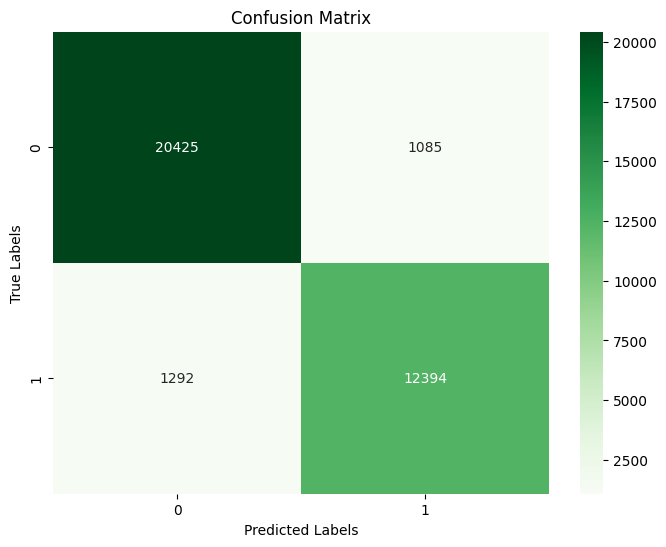

In [15]:
# 模型评估
def evaluate(model, dataloader):
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in dataloader:
            b_input_ids, b_labels = batch
            outputs = model(b_input_ids, attention_mask=(b_input_ids != 0))
            logits = outputs.squeeze()

            predictions.extend(list(np.round(torch.sigmoid(logits).numpy())))
            true_labels.extend(b_labels.to('cpu').numpy())

    print("Classification Report:")
    print(classification_report(true_labels, predictions, labels=[1, 0], digits=4))

    accuracy = accuracy_score(true_labels, predictions)
    print(f'Accuracy: {accuracy * 100:.2f}%')
    return predictions, true_labels


predictions, true_labels = evaluate(model, test_dataloader)
conf_matrix = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Greens', fmt='d')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()